# Search Prediction

> A highly flexible model for forecasting search clicks for a given budget

In [ ]:
#| eval: false
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import warnings

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from typing import Callable, Tuple, Protocol
from abc import ABC, abstractmethod

from pymc_marketing.mmm.transformers import batched_convolution
import pymc_marketing as pm_mrk
from pymc_marketing.prior import handle_dims
import pymc as pm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import pytensor.tensor as pt
import dowhy

from search_forecast.utils.data_gen import generate_data_search_data
from search_forecast.wrapper.pymc_wrapper import (
    Prior, HSGP, HSGPPeriodic,
    YearlyFourier, Data, WeeklyFourier
)
from search_forecast.utils.data_gen import (
    hill
)

In [ ]:
#| hide
causal_graph = """digraph {
geo -> search_volume;
time -> search_volume;
time -> budget;
time -> observed_clicks;
geo -> budget;
budget -> impressions;
search_volume -> impressions;
impressions -> observed_clicks;
}"""

In [ ]:
#| hide
data = generate_data_search_data()

## An Overview of Search



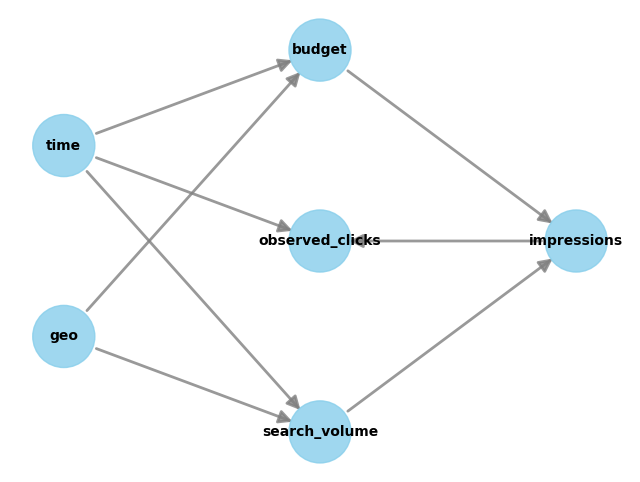

In [ ]:
#| echo: False
model = dowhy.CausalModel(
    data=data.to_dataframe(),
    graph=causal_graph.replace("\n", " "),
    treatment="budget",
    outcome="observed_clicks",
)
model.view_model()

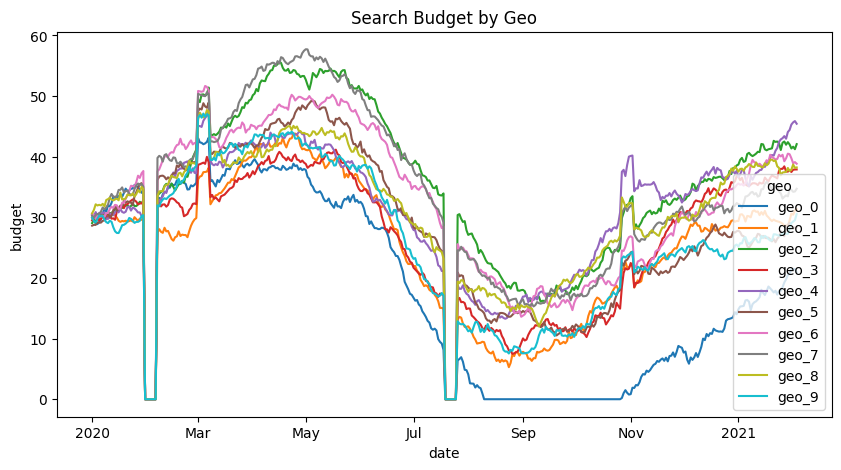

In [ ]:
#| echo: False
plt.figure(figsize=(10, 5))
ax = data.budget.plot.line(x="date", hue="geo");
plt.title("Search Budget by Geo");

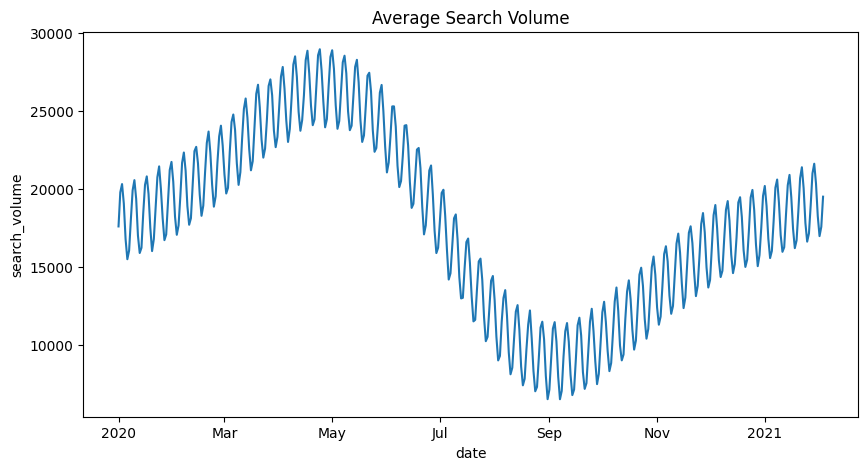

In [ ]:
#| echo: False
plt.figure(figsize=(10, 5))
data.search_volume.mean('geo').plot()
plt.title("Average Search Volume");

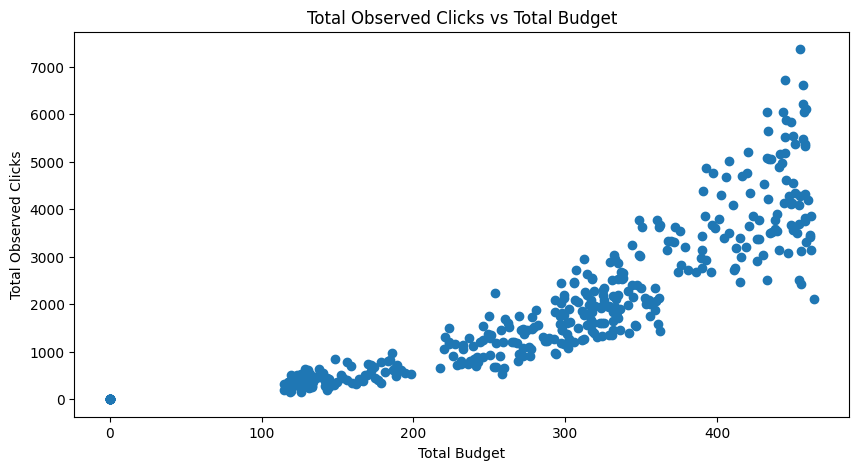

In [ ]:
#| echo: False
plt.figure(figsize=(10, 5))
plt.scatter(data.budget.sum("geo").values, (data.observed_clicks.sum("geo")).values)
plt.xlabel("Total Budget")
plt.ylabel("Total Observed Clicks")
plt.title("Total Observed Clicks vs Total Budget");

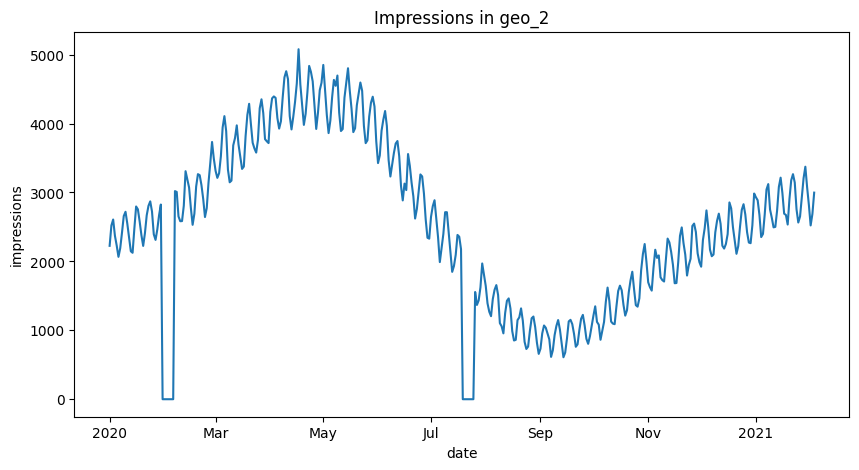

In [ ]:
#| echo: False
plt.figure(figsize=(10, 5))
data.impressions.sel(geo="geo_2").plot.line(x="date")
plt.title("Impressions in geo_2");

## Assign Containers for Data

By using 

In [ ]:
## Data
time_data = Data('time', dims=('date'))
budget_data = Data('budget', dims=('date', 'geo'))

In [ ]:
## Prior for long-term periodicity
ls_long_periodic = Prior(
    'ls_lp', 
    prior_name="Gamma", 
    alpha=1, 
    beta=1/5)
scale_long_periodic = Prior(
    'scale_lp',
    prior_name="Exponential",
    lam=1/100.0)
long_periodic = HSGPPeriodic(
    "long_term_periodic",
    m=40,
    ls=ls_long_periodic,
    scale=scale_long_periodic,
    dims=('date', 'geo'),
    period=365 # yearly
)

## Short-term periodicity for search volume assume similar across geo
weekly_periodic = WeeklyFourier(
    name='weekly_periodic',
    n_order=3,
    prefix='weekly_search_volume',
    dims=('date',)
    )
    

daily_geo_shocks_search_volume = Prior(
        "daily_geo_shocks_search_volume",
        prior_name="Normal", 
        mu=0, 
        sigma=Prior(
            "daily_geo_shocks_search_volume_scale", 
            prior_name="HalfCauchy", 
            beta=1
        ), 
        dims=('date', 'geo')
    )
    
base_volume = Prior(
        "base_volume",
        prior_name="Normal",
        mu=Prior(
            "base_volume_mu", 
            prior_name="Normal", 
            mu=15000, 
            sigma=1000),
        sigma=Prior(
            "base_volume_sigma",
            prior_name="HalfNormal", 
            sigma=500),
        dims=('geo',)
    )



ls_short_periodic = Prior("ls_sp", prior_name="Gamma", alpha=1, beta=1/30)
scale_short_periodic = Prior("scale_sp", prior_name="Exponential", lam=1)

short_periodic_ctr= HSGPPeriodic(
    "short_term_periodic_ctr",
    m=40,
    ls=ls_long_periodic,
    scale=scale_long_periodic,
    dims=('date', 'geo'),
    period=7 # weekly
)

ls_long_periodic_ctr = Prior(
    "ls_lp_ctr",
    prior_name="Gamma", 
    alpha=1, 
    beta=1/5
    )
scale_long_periodic_ctr = Prior(
    "scale_lp_ctr", 
    prior_name="Exponential", 
    lam=1
    )
long_periodic_ctr = HSGPPeriodic(
    "long_term_periodic_ctr",
    m=40,
    ls=ls_long_periodic_ctr,
    scale=scale_long_periodic_ctr,
    dims=('date', 'geo'),
    period=365 # yearly
)

ctr_season = (
    short_periodic_ctr 
    + long_periodic_ctr 
    + Prior("base_ctr", prior_name="Normal", mu=0, sigma=1)
)

search_volume_lam = ((
    long_periodic 
    + weekly_periodic
    + base_volume
    + daily_geo_shocks_search_volume
    )(time_data)).transform(pt.softplus)

multiplier = Prior("search_volume_multiplier", prior_name="Beta", alpha=0.5, beta=0.5, dims=tuple())
competitor_pressure = Prior("competitor_pressure", prior_name="HalfCauchy", beta=1, dims=tuple())

def budget_transform(multiplier, competitor_pressure, budget):
    numerator = multiplier * budget
    denominator = budget + competitor_pressure
    return numerator / denominator
    
impression_rate = budget_transform(
    multiplier=multiplier,
    competitor_pressure=competitor_pressure,
    budget=budget_data
)

click_rate = (ctr_season(time_data)).transform(pt.sigmoid)
        

In [ ]:
coords = {
    "date": data.date.values[:100],
    "geo": data.geo.values
}
with pm.Model(coords=coords) as search_volume_model:
    # Search volume
    lam = handle_dims(search_volume_lam.apply(np.arange(100)), search_volume_lam._dims, ("date", "geo"))
    search_volume_obs = pm.Poisson(
        "search_volume_obs",
        mu=lam,
        dims=("date", "geo"),
    )
    imp_rate = handle_dims(impression_rate.apply(data.budget.isel(date=slice(None, 100)).values), impression_rate._dims, ("date", "geo"))
    impressions_obs = pm.Binomial(
        "impressions_obs",
        n=search_volume_obs,
        p=imp_rate,
        dims=("date", "geo"),
    )
    c_rate = handle_dims(click_rate.apply(data.budget.values[:100]), click_rate._dims, ("date", "geo"))

    clicks_obs = pm.Binomial(
        "clicks_obs",
        n=impressions_obs,
        p=c_rate,
        dims=("date", "geo"),
    )
    
# observed_model = pm.observe(search_volume_model, {
#     "search_volume_obs": data.search_volume.values[:100],
#     "impressions_obs": data.impressions.values[:100],
#     "clicks_obs": data.observed_clicks.values[:100],
# })

def partial_observe(model, obs_data, input_data, coords, target_accept=.70):
    with pm.observe(model, obs_data):
        pm.set_data(input_data, coords=coords)
        trace = pm.sample(1000, tune=1000, target_accept=target_accept, nuts_sampler='nutpie')
    return trace

search_volume_trace = partial_observe(
    search_volume_model, 
    {'search_volume_obs': data.search_volume.values[:100],
    'impressions_obs': data.impressions.values[:100],
    'clicks_obs': data.observed_clicks.values[:100]}, 
    {'time': data['time'].values[:100],
    'budget': data.budget.values[:100]}, 
    coords)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,764,0,0.07,63
,519,0,0.08,63
,641,0,0.06,63
,765,0,0.04,63


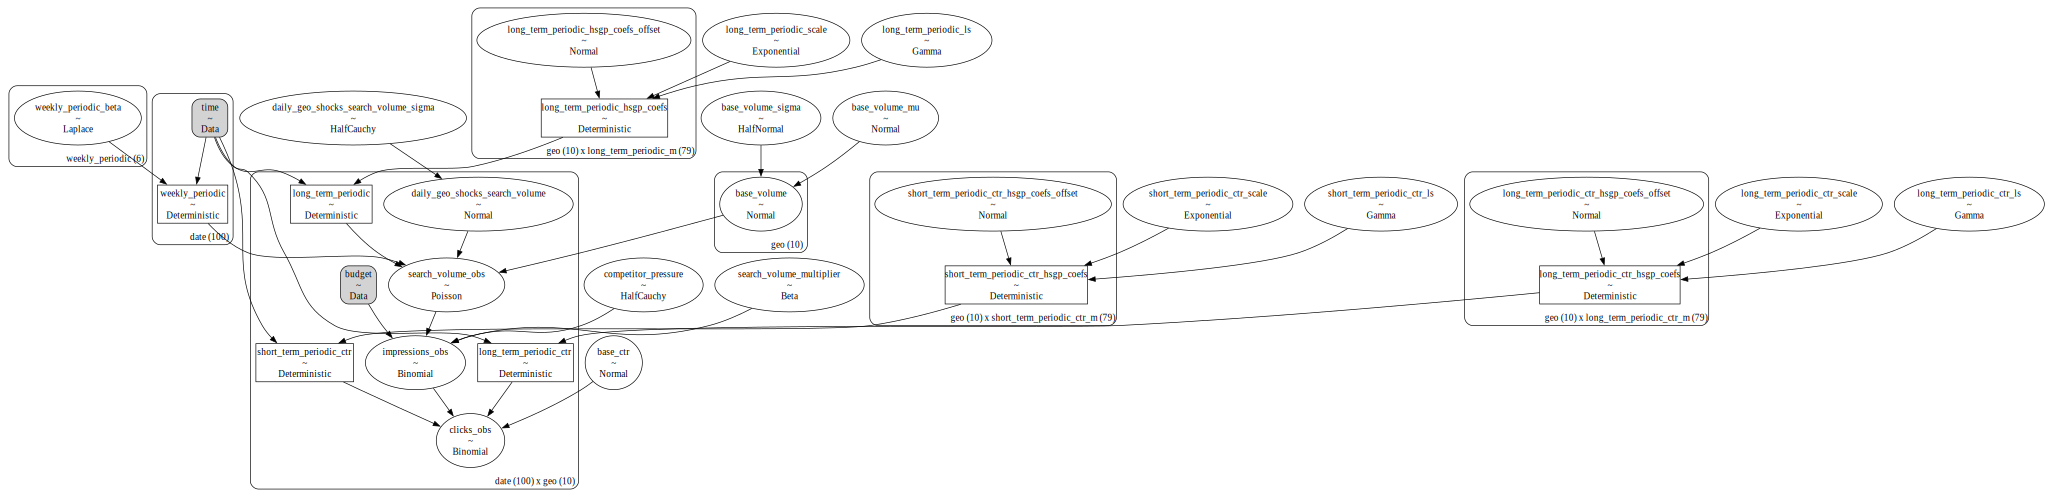

In [ ]:
pm.model_to_graphviz(search_volume_model)